# Colossal-AI: A Unified Deep Learning System For Large-Scale Parallel Training

<p><b>Requirements:</b>

PyTorch >= 1.11 and PyTorch <= 2.1<br/>
Python >= 3.7<br/>
CUDA >= 11.0<br/>
NVIDIA GPU Compute Capability >= 7.0 (V100/RTX20 and higher)<br/>
Linux OS</p>

### Import Required Packages

In [1]:
import os
import time
import warnings

import torch
import torch.distributed as dist
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim import Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from tqdm import tqdm

import colossalai
from colossalai.accelerator import get_accelerator
from colossalai.booster import Booster
from colossalai.booster.plugin import TorchDDPPlugin
from colossalai.cluster import DistCoordinator
from colossalai.nn.optimizer import HybridAdam

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

warnings.filterwarnings("ignore")

/user/ngupta22/.local/lib/python3.9/site-packages/colossalai/shardformer/layer/normalization.py:45: UserWarning: Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel
  warnings.warn("Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel")


### Set up distributed training environment variables

In [2]:
os.environ["RANK"] = "0"  # Rank of the current process in distributed environment
os.environ["LOCAL_RANK"] = "0"  # Local rank of the current process
os.environ["WORLD_SIZE"] = "1"  # Total number of processes
os.environ["MASTER_ADDR"] = "localhost"  # Address of the master node
os.environ["MASTER_PORT"] = "1234"  # Port for communication

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define Hyperparameters

In [4]:
# Hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
GAMMA = 0.3

### Initialize ColossalAI, Plugin and Booster

In [5]:
colossalai.launch_from_torch(config={}) #comment this line if already launched
coordinator = DistCoordinator()

plugin = TorchDDPPlugin()
booster = Booster(plugin=plugin)

[04/14/24 15:44:00] INFO     colossalai - colossalai - INFO:                                                       
                             /user/ngupta22/.local/lib/python3.9/site-packages/colossalai/initialize.py:67 launch

                    INFO     colossalai - colossalai - INFO: Distributed environment is initialized, world size: 1

### Transformation and Dataloaders 

In [6]:
# Transform
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST dataset
data_path = os.environ.get("DATA", "./data")
with coordinator.priority_execution():
    train_dataset = torchvision.datasets.MNIST(
        root=data_path, train=True, transform=transform_train, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root=data_path, train=False, transform=transform_test, download=True
    )

# Data loader
train_dataloader = plugin.prepare_dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = plugin.prepare_dataloader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

### Grayscale or RGB Image check

In [7]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in train_dataloader:
    print(image.shape[1])
    break

1


### Sample Images

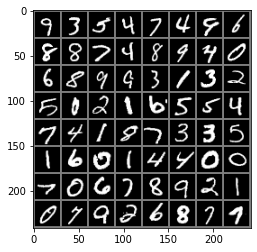

9 - nine 3 - three 5 - five 4 - four 7 - seven 4 - four 9 - nine 6 - six 8 - eight 8 - eight 7 - seven 4 - four 8 - eight 9 - nine 4 - four 0 - zero 6 - six 8 - eight 9 - nine 9 - nine 3 - three 1 - one 3 - three 2 - two 5 - five 0 - zero 2 - two 1 - one 6 - six 5 - five 5 - five 4 - four 7 - seven 4 - four 1 - one 8 - eight 7 - seven 3 - three 3 - three 5 - five 1 - one 6 - six 0 - zero 1 - one 4 - four 4 - four 0 - zero 0 - zero 7 - seven 0 - zero 6 - six 7 - seven 8 - eight 9 - nine 2 - two 1 - one 0 - zero 7 - seven 9 - nine 2 - two 6 - six 8 - eight 7 - seven 7 - seven


In [8]:
classes = train_dataset.classes

# Print batch size sample images from dataset
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

### Define Model Architecture

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
modelCNN = CNN()
print("\nModel Architecture:\n")
print(modelCNN)


Model Architecture:

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### Prepare Criterion, Optimizer, Learning Rate Scheduler

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = HybridAdam(modelCNN.parameters(), lr=LEARNING_RATE)
lr_scheduler = MultiStepLR(optimizer, milestones=[20, 40, 60, 80], gamma=GAMMA)

[extension] Compiling the JIT cpu_adam_x86 kernel during runtime now
[extension] Time taken to compile cpu_adam_x86 op: 0.40125322341918945 seconds
[extension] Compiling the JIT fused_optim_cuda kernel during runtime now
[extension] Time taken to compile fused_optim_cuda op: 0.2330174446105957 seconds


### Boost with ColossalAI

In [12]:
model, optimizer, criterion, _, lr_scheduler = booster.boost(
    model=modelCNN, optimizer=optimizer, criterion=criterion, lr_scheduler=lr_scheduler
)

### Define Model Training

In [13]:
def modelTraining(
    epochs: int,
    model: nn.Module,
    optimizer: Optimizer,
    criterion: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    booster: Booster,
    coordinator: DistCoordinator,
):

    startTime = time.time()

    training_loss_plt_arr = []
    testing_loss_plt_arr = []

    for epoch in range(epochs):
        
        # Training Loss
        model.train()
        train_loss = 0.0
        with tqdm(train_dataloader, desc=f"Epoch [{epoch + 1}/{epochs}]", disable=not coordinator.is_master()) as pbar:
            for images, labels in pbar:
                images = images.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                booster.backward(loss, optimizer)
                optimizer.step()
                optimizer.zero_grad()

                # Print log info
                pbar.set_postfix({"Train loss": loss.item()})

                train_loss += loss.item()

            training_loss_plt_arr.append(train_loss)


        # Testing Loss
        model.eval()
        test_loss = 0.0
        with tqdm(test_dataloader, desc=f"Epoch [{epoch + 1}/{epochs}]", disable=not coordinator.is_master()) as pbar:
            for images, labels in pbar:
                images = images.to(device)
                labels = labels.to(device)
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                booster.backward(loss, optimizer)
                optimizer.step()
                optimizer.zero_grad()

                # Print log info
                pbar.set_postfix({"Test loss": loss.item()})

                test_loss += loss.item()

            testing_loss_plt_arr.append(test_loss)
            
        lr_scheduler.step()

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, testing_loss_plt_arr

### Plot Losses

In [14]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Testing loss')
    plt.legend()
    plt.show()

### Define Model Testing

In [15]:
def loadersAccuracy(model, loader):
    
    model.eval()
    correct = torch.zeros(1, dtype=torch.int64, device=get_accelerator().get_current_device())
    total = torch.zeros(1, dtype=torch.int64, device=get_accelerator().get_current_device())
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []
    
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.flatten()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        trueLabels.extend(labels.tolist())
        predictedLabels.extend(predicted.tolist())
        
        # ROC
        preds = F.softmax(outputs, dim=1)
        trueLabelsROC.extend(labels.tolist())
        predictedLabelsROC.extend(preds.tolist())
        
    dist.all_reduce(correct)
    dist.all_reduce(total)
    accuracy = (correct.item() / total.item()) * 100
    
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC
    

def perfEvaluation(model, train_dataloader, test_dataloader):

    model.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC = loadersAccuracy(model, test_dataloader)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    train_accuracy, _, _, _, _ = loadersAccuracy(model, train_dataloader)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Test']
    accuracies = [train_accuracy, test_accuracy]
    bars = plt.bar(labels, accuracies, color=['red', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    # Adjust text position to be above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=10)
    test_predictedLabelsROC = test_predictedLabelsROC.to(device)
    test_trueLabelsROC = test_trueLabelsROC.to(device)
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)

### Model Evaluation

Epoch [20/20]: 100%|██████████| 157/157 [00:02<00:00, 63.07it/s, Test loss=0]       


Finished Training

Time to train: 5min 52sec


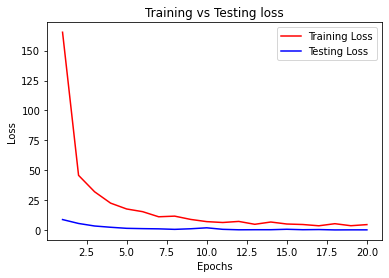

Accuracy on the testing dataset = 99.99
Precision = 1.00
Recall = 1.00
Fscore = 1.00


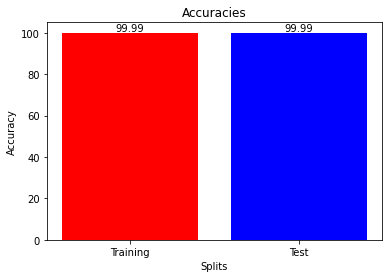

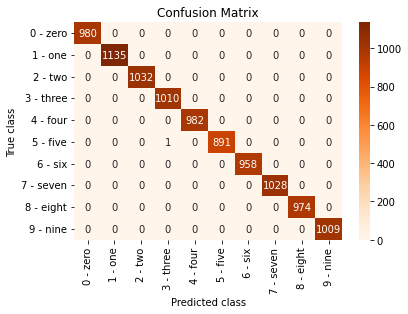

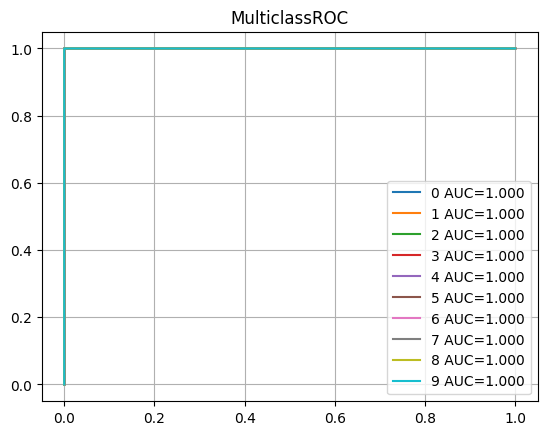

In [16]:
training_loss_plt_arr, testing_loss_plt_arr = modelTraining(NUM_EPOCHS, model, optimizer, criterion, train_dataloader, test_dataloader, booster, coordinator)
LossesPlot(training_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(modelCNN, train_dataloader, test_dataloader)

### References

1. https://numpy.org/doc/
1. https://matplotlib.org/stable/index.html
1. https://scikit-learn.org/stable/
1. https://seaborn.pydata.org/
1. https://pytorch.org/tutorials/
1. https://pytorch.org/vision/main/models/vision_transformer.html
1. https://colossalai.org/docs/get_started/installation/
1. https://github.com/hpcaitech/ColossalAI
1. https://github.com/hpcaitech/ColossalAI/blob/main/examples/images/resnet/train.py
1. Data Loading, Model Training and Testing is based on CSE 676 Deep Learning Assignment 1 Part 1 and Bonus submission by Nikhil Gupta